# Combining Thompson Sampling Results

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns

## Process belief function

In [138]:
def process_retro(retro, best, percentile=0.5):
    """ Gathers the percentile of the retrospective belief function
    """

    retro_list = []
    for acq_fn in retro['Acquisition Function'].unique():

        retro_subset = retro[retro['Acquisition Function'] == acq_fn]

        num_datapoints = best[
            (best['Acquisition Function'] == acq_fn) &
            (best['Trial'] == 0)
        ]['Datapoints Acquired'].values

        for trial in retro_subset.Trial.unique():

            for round_ in retro_subset.Round.unique():

                round_subset = retro_subset[np.logical_and(retro_subset['Round'] == round_, retro_subset['Trial'] == trial)]
                round_values = round_subset['Value']
                
                retro_list.append(
                    {
                        'Acquisition Function': acq_fn,
                        'Trial': trial,
                        'Datapoints Acquired': num_datapoints[round_],
                        'Round': round_,
                        'Belief Function': 'GlobalMax',
                        'Belief Value': np.sort(round_values)[int(len(round_values)*percentile)],
                    }
                )

    retro_df = pd.DataFrame(retro_list)
    return retro_df


def process_pro(pro, best):
    """ Gathers the percentile of the retrospective belief function
    """
    pro_list = []
    for acq_fn in best['Acquisition Function'].unique():

        pro_subset = pro[pro['Acquisition Function'] == acq_fn]
        best_subset = best[best['Acquisition Function'] == acq_fn]
        num_datapoints = best_subset[best_subset['Trial'] == 0]['Datapoints Acquired'].values

        for trial in pro_subset.Trial.unique():

            for round_ in pro_subset.Round.unique():
                
                round_values = pro_subset[np.logical_and(pro_subset['Round'] == round_, pro_subset['Trial'] == trial)]['Value']
                round_best = best[np.logical_and(best['Round'] == round_, best['Trial'] == trial)]['Value'].iloc[0]
                
                for belief_fn in ['Prob. Improvement', 'Expected Improvement']:
                    
                    if belief_fn == 'Prob. Improvement':
                        belief_value = (round_values > round_best).mean()
                    else:
                        belief_value = (np.maximum(round_values - round_best, 0)).mean()
                    
                    pro_list.append(
                        {
                            'Acquisition Function': acq_fn,
                            'Trial': trial,
                            'Datapoints Acquired': num_datapoints[round_],
                            'Round': round_,
                            'Belief Function': belief_fn,
                            'Belief Value': belief_value,
                        }
                    )

    pro_df = pd.DataFrame(pro_list)
    
    return pro_df

In [139]:
from tqdm import tqdm

processed_dfs = []
for q in tqdm([10, 96]):
    best = pd.concat([
        pd.read_csv(f'./out/best_ThompsonSampling_{q}.csv', index_col=0),
        pd.read_csv(f'./out/best_Random_{q}.csv', index_col=0),
        pd.read_csv(f'./out/best_Human_96.csv', index_col=0)
    ])

    pro = pd.concat([
        pd.read_csv(f'./out/pro_ThompsonSampling_{q}.csv', index_col=0),
        pd.read_csv(f'./out/pro_Random_{q}.csv', index_col=0),
        pd.read_csv(f'./out/pro_Human_96.csv', index_col=0)
    ])

    retro = pd.concat([
        pd.read_csv(f'./out/retro_ThompsonSampling_{q}.csv', index_col=0),
        pd.read_csv(f'./out/retro_Random_{q}.csv', index_col=0),
        pd.read_csv(f'./out/retro_Human_96.csv', index_col=0)
    ])
    
    retro_processed = process_retro(retro, best, percentile=0.5)
    pro_processed = process_pro(pro, best)
    retro_processed['q'] = q
    pro_processed['q'] = q
    processed_dfs.extend([retro_processed, pro_processed])

processed = pd.concat(processed_dfs)

100%|█████████████████████████████████████████████| 2/2 [00:22<00:00, 11.03s/it]


# Plot grid.

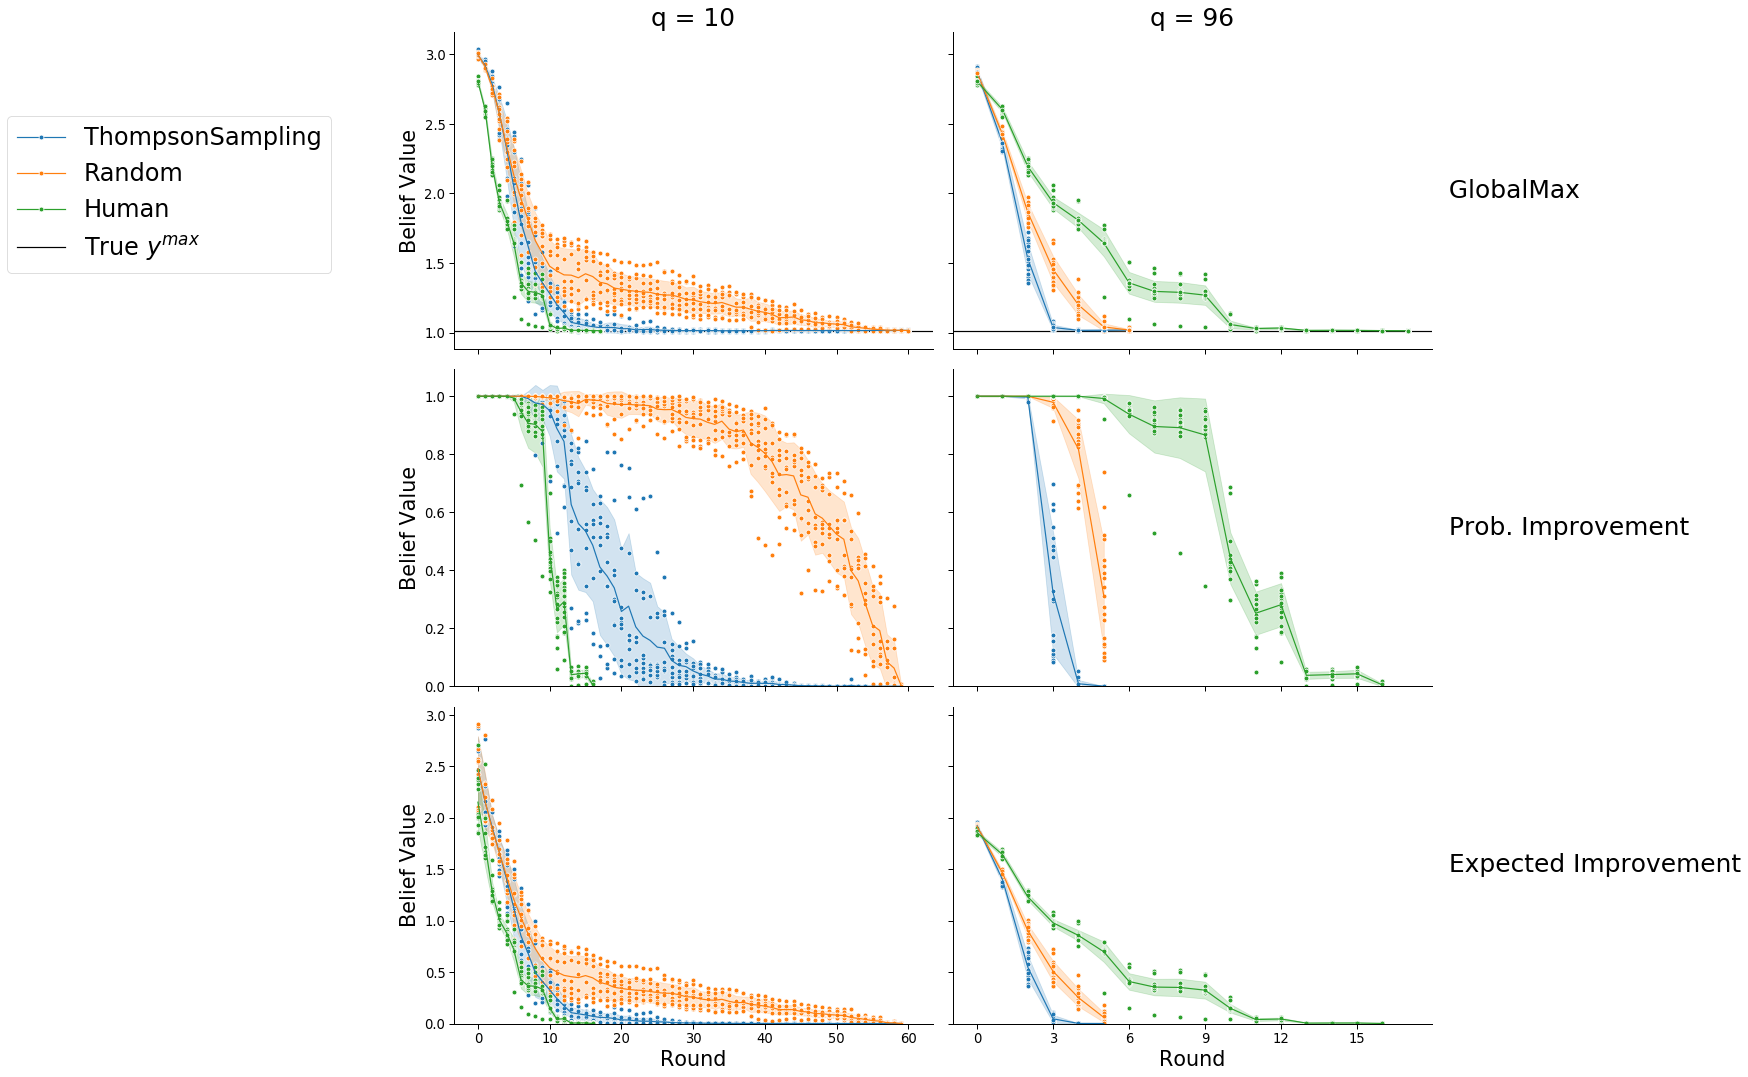

In [214]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import pinot
ds = pinot.data.moonshot_sorted()
actual_best = max([d[1].item() for d in ds])

criterion = 'Round'

with sns.plotting_context('paper', font_scale=1.5):

    g = sns.FacetGrid(
        processed,
        col='q',
        row='Belief Function',
        hue='Acquisition Function',
        aspect=1.5,
        height=5,
        sharey='row',
        sharex='col',
        margin_titles=True,
    )

    g = g.map(sns.lineplot, criterion, 'Belief Value', ci='sd')
    g = g.map(sns.scatterplot, criterion, 'Belief Value')
    
    # fix axis
    if criterion == 'Round':
        for idx in range(len(g.axes[:,1])):
            g.axes[:,1][idx].xaxis.set_major_locator(mticker.MultipleLocator(3))
    
    # add horizontal rule for true max
    g.axes[0, 0].axhline(actual_best, color='black', label='True $y^{max}$', zorder=-1)
    g.axes[0, 1].axhline(actual_best, color='black', label='True $y^{max}$', zorder=-1)
    
    # fix x axes on second and third rows
    g.axes[1, 0].set_ylim(0.0,)
    g.axes[1, 1].set_ylim(0.0,)
    g.axes[2, 0].set_ylim(0.0,)
    g.axes[2, 1].set_ylim(0.0,)
    
    # from https://cduvallet.github.io/posts/2018/11/facetgrid-ylabel-access
    
    # Iterate through each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title(),
                         fontsize='xx-large')

        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='xx-large')
            # Remove the original text
            ax.texts[0].remove()
            ax.texts[0].remove()

    
    handles_labels = {'handles': [], 'labels': []}
    handles, labels = g.axes[0][1].get_legend_handles_labels()[:3]
    for idx in range(3):
        handles[idx].set_marker('o')
    
    plt.legend(
        handles[:4],
        labels[:4],
        loc='upper left',
        numpoints=1,
        fontsize=24,
        bbox_to_anchor=(-2, 2.9)
    )
    
    plt.show()
    
    # save figure
    g.savefig(f'belief_function_{criterion}.png', dpi=300)